In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

from myPackage import cmdInput
from meshGenSheets1d import makeMesh1D
import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()
from myPackage import evalOnLine
from myPackage import Draw1d as Draw



In [2]:
lambda1 = 1
lambda2 = 10

order0 = 2

In [112]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.05



modelHalfAir=True



## 1. Only Smooth
### 1.1. Reference Solution Only Smooth

In [113]:



meshRef = makeMesh1D(num_sheets=numSheets, size_all=D, size_core=d, ff=ff, 
        MS = False, use_gap=True, steps_air = [1, 1, 1, 1], steps_Fe = [0.1, 1, 1, 1, 1, 0.1], steps_gap=[1], 
        fullProblemX=True)
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))



Boundaries {'ileft', 'left', 'iright', 'right'}
Materials {'medium', 'gap', 'air'}


In [114]:
lam = meshRef.MaterialCF({"medium":lambda2, "air":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("medium|gap"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 25.573709127542408     
CG iteration 2, residual = 7.36051540878087e-13     


energy:	39.42671426288168


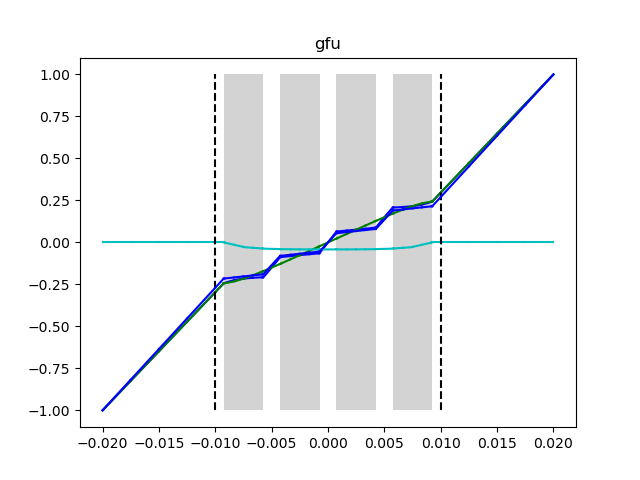

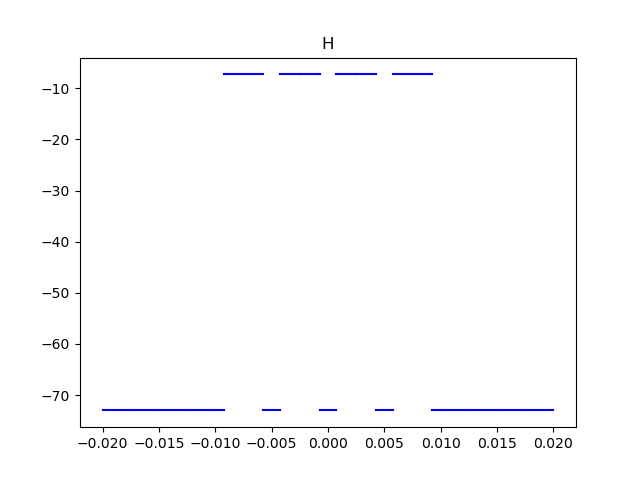

In [115]:
dFe = d/numSheets * ff
d0 = d/numSheets * (1-ff)
def drawSheets(min=-1, max = 1):
    xpos = -d/2
    plt.plot([xpos, xpos], [min, max], 'k--')
    for i in range(numSheets):
        xpos += d0/2
        plt.fill([xpos, xpos, xpos+dFe, xpos+dFe], [min, max, max, min], 'lightgray')
        xpos += dFe + d0/2
    plt.plot([xpos, xpos], [min, max], 'k--')
        
        


print(f"energy:\t{energy_ref}")
drawSheets()
Draw(sol_ref, clear=False )
plt.show()
Draw( -grad(sol_ref)[0], meshRef, "H")
plt.show()



### 1.2 Multiscale only Smooth

('air', 'medium')
{'ileft', 'left', 'iright', 'right'}


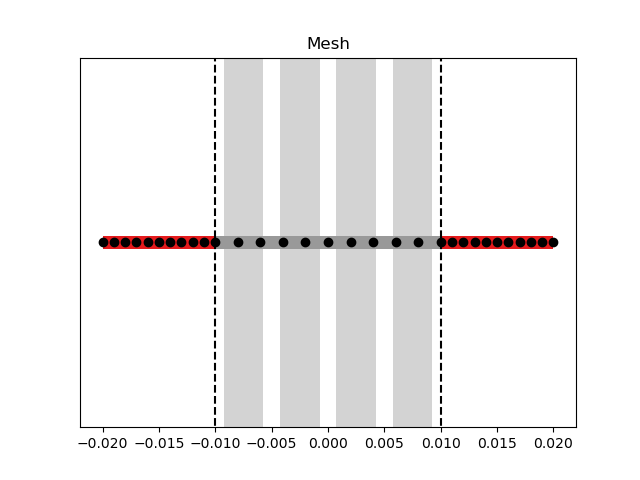

In [116]:
meshMS = makeMesh1D(num_sheets=numSheets, size_all=D, size_core=d, ff=ff, 
        MS = True, use_gap=True, steps_air = [1]*10, steps_Fe = [1]*10, steps_gap=[1], 
        fullProblemX=True, modelHalfAir=modelHalfAir)
print(meshMS.GetMaterials())
print(set(meshMS.GetBoundaries()))

plt.figure(1)
plt.clf()
drawSheets(-1, 1)
Draw(meshMS, clear=False)
plt.show()
from myPackage import drawBnd

# plt.figure(2)
# drawBnd(meshMS,"right", drawFunc=Draw, block=False)
# Draw(meshMS, clear=False, show=True)
# plt.plot()


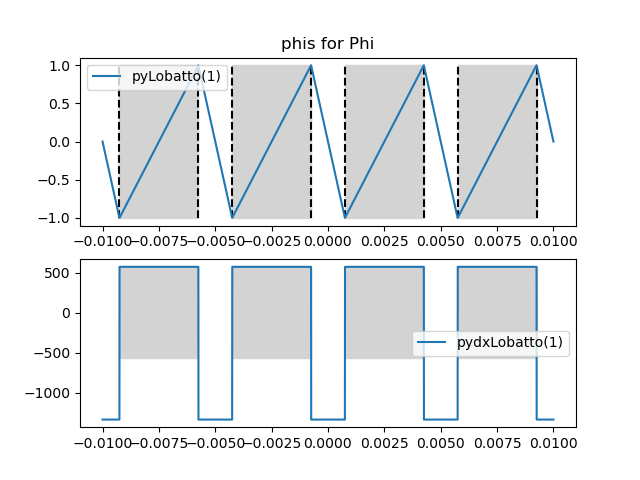

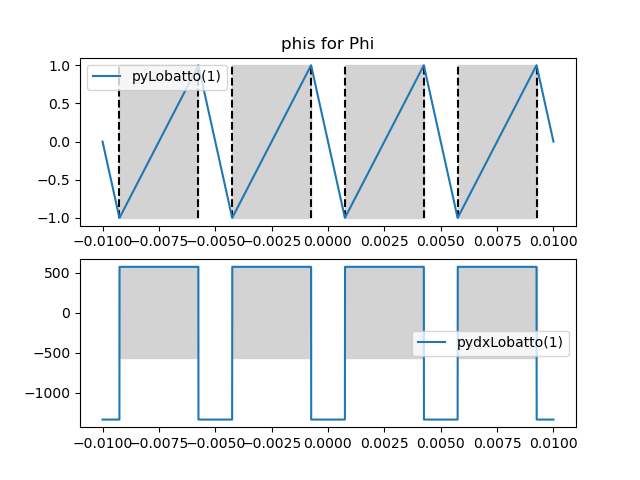

CG iteration 1, residual = 43.05826980430285     
CG iteration 2, residual = 2.225645343844778e-14     
anorm 37633.88287538635
Norm soll diff 0.07291323809904492 %
diff energy 39.42671426288022 39.42671426288168 -1.4637180356658064e-12 -3.7125032177581816e-12 %
-grad(u0_outer) - grad(u1 * pyLobatto(1))


In [128]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = dFe
cl_Phi.d0 = d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 0


force_full_Phi = True
moartaring = False

smoothB_fun_Fe = lambda x: 1e3 * lambda1/lambda2 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smoothB_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)


smoothBPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothB_fun_Fe, smoothB_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothBPhi2", order="smB2", modelHalfAir=False)

oszi_Fe = lambda x: 1 
oszi_0 = lambda x: 1 

oszi_Phi_Fe = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [oszi_Fe, oszi_0], numSheets, ff, cl_Phi.orientation, name = "osziFe", order="osziFe", modelHalfAir=False, inAir=False)


zickzack_Fe = lambda x : (x+cl_Phi.dFe/2)/dFe
zickzack_0 = lambda x : (-x+cl_Phi.dFe/2 + cl_Phi.d0)/d0

zickzack = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [zickzack_Fe, zickzack_0], numSheets, ff, cl_Phi.orientation, name = "zickzack", order="ziza", modelHalfAir=False)

zackzick_Fe = lambda x : (-x+cl_Phi.dFe/2)/dFe
zackzick_0 = lambda x : (x-cl_Phi.dFe/2)/d0

zackzick = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [zackzick_Fe, zackzick_0], numSheets, ff, cl_Phi.orientation, name = "zickzack", order="ziza", modelHalfAir=False)

def calcMultiscale(useGradients=True, drawPhis=True):

    smoothbnd = "ileft|iright"
    # microshape functions
    orderPhi = [
            cl_Phi([pyPhiConst(), pyPhiZero()], fes_order=order0, material="medium", dirichlet="", useGradients=True, useAbsolutes=False),        
            # cl_Phi([zickzack, zickzack.getDiff()], fes_order=order0, material="medium", dirichlet="", useGradients=True, useAbsolutes=False),        
            # cl_Phi([zackzick, zackzick.getDiff()], fes_order=order0, material="medium", dirichlet="", useGradients=True, useAbsolutes=False),        
            # cl_Phi([oszi_Phi_Fe, pyPhiZero()], fes_order=order0, material="medium", dirichlet="", useGradients=True, useAbsolutes=False),    
            # cl_Phi(1, fes_order=2, material="medium", dirichlet="", useGradients=True, 
            #         specialFirstLast=True, 
            #         specialFirstLast_func=[lambda x : 1/cl_Phi.dFe*(x+cl_Phi.dFe/2), lambda x:1/cl_Phi.dFe*(x-cl_Phi.dFe/2)], 
            #         specialFirstLast_dzfunc=[lambda x : 1/cl_Phi.dFe, lambda x : 1/cl_Phi.dFe], 
            #         ),  
            cl_Phi(1, fes_order=1, material="medium", dirichlet="", useGradients=useGradients, modelHalfAir=True), 
            # cl_Phi([smoothBPhi2, smoothBPhi2.getDiff()], fes_order=order0, material="medium", dirichlet="", useGradients=True),
            # cl_Phi(2, fes_order=order0, material="medium", dirichlet="", inIron=False, modelHalfAir=False), 

        ]




    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi)
        cl_Phi.plotDirectEvaluated(orderPhi)



    VSpace = []
    # u0 
    domains_outer = "air"
    if not moartaring:
        domains_outer += "|medium"
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right", definedon=meshMS.Materials(domains_outer))) 
    
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    # phi_i = orderPhi[0]
    # VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    # phi_i = orderPhi[1]
    # VSpace.append(NumberSpace(meshMS, definedon=meshMS.Materials(phi_i.material)))

    VSpace = FESpace(VSpace)




    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    gradgradMS = cl_gradgradMS(orderPhi, sol, addPhi0Outer=True)

    gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)

    # gradgradMS.setElementCouplingMatrix(0, 0, 8)
    # gradgradMS.setElementCouplingMatrix(1, 1, 2585714.286)


    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(gradgradMS.trials[0]) * grad(gradgradMS.tests[0]) * dx("air")
    a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack, gradgradMS.gradv_pack, lambda2, lambda1, force_full_Phi=force_full_Phi) * dx("medium")

    h = specialcf.mesh_size

    u_start = 1 if moartaring else 0
    d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2



    # absolutes
    # u_range = range(u_start, len(gradgradMS.u_pack))
    u_range = list(range(u_start, len(gradgradMS.u_pack)))
    u_range = u_range

    um_left = sum(gradgradMS.u_pack[i][0] *  gradgradMS.u_pack[i][1].DirectEvaluate(d_coupling) for i in u_range)
    vm_left = sum(gradgradMS.v_pack[i][0] *  gradgradMS.v_pack[i][1].DirectEvaluate(d_coupling) for i in u_range)

    um_right = sum(gradgradMS.u_pack[i][0] *  gradgradMS.u_pack[i][1].DirectEvaluate(-d_coupling) for i in u_range)
    vm_right = sum(gradgradMS.v_pack[i][0] *  gradgradMS.v_pack[i][1].DirectEvaluate(-d_coupling) for i in u_range)

    jump_u_right = gradgradMS.u_pack[0][0] - um_right
    jump_u_left = gradgradMS.u_pack[0][0] - um_left

    jump_v_right = gradgradMS.v_pack[0][0] - vm_right
    jump_v_left = gradgradMS.v_pack[0][0] - vm_left

    if True:
        # gradients
        grad_range = range(u_start, len(gradgradMS.gradu_pack))
        # grad_range = [1] #+ list(range(4, len(gradgradMS.gradu)))
        
        gradum_left = sum(gradgradMS.gradu_trace_n_pack[i][0] * gradgradMS.gradu_trace_n_pack[i][1].DirectEvaluate(d_coupling) for i in grad_range)
        gradvm_left = sum(gradgradMS.gradv_trace_n_pack[i][0] * gradgradMS.gradv_trace_n_pack[i][1].DirectEvaluate(d_coupling) for i in grad_range)

        gradum_right = sum(gradgradMS.gradu_trace_n_pack[i][0] * gradgradMS.gradu_trace_n_pack[i][1].DirectEvaluate(-d_coupling) for i in grad_range)
        gradvm_right = sum(gradgradMS.gradv_trace_n_pack[i][0] * gradgradMS.gradv_trace_n_pack[i][1].DirectEvaluate(-d_coupling) for i in grad_range)

        lambda_inner = lambda1 if modelHalfAir else lambda2

        jump_Bu_right = lambda1 * gradgradMS.gradu_trace_n_pack[0][0] - lambda_inner * gradum_right
        jump_Bu_left = lambda1 * gradgradMS.gradu_trace_n_pack[0][0] - lambda_inner * gradum_left

        jump_Bv_right = lambda1 * gradgradMS.gradv_trace_n_pack[0][0] - lambda_inner * gradvm_right
        jump_Bv_left = lambda1 * gradgradMS.gradv_trace_n_pack[0][0] - lambda_inner * gradvm_left


        # jump_Hu_right = gradgradMS.gradu_trace_n_pack[0][0] - gradgradMS.gradu_trace_n_pack[2][0]
        # jump_Hu_left = gradgradMS.gradu_trace_n_pack[0][0] - gradgradMS.gradu_trace_n_pack[2][0]

        # jump_Hv_right = gradgradMS.gradv_trace_n_pack[0][0] - gradgradMS.gradu_trace_n_pack[2][0]
        # jump_Hv_left = gradgradMS.gradv_trace_n_pack[0][0] - gradgradMS.gradu_trace_n_pack[2][0]

    # couple u
    if False:
        #[u][v]
        print("-------[u][v]-------")
        alpha = 1000
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.v_pack[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.v_pack[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.v_pack[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.v_pack[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        # a += alpha*order0**2/h  * (jump_u_right)  * (jump_v_right)  *ds("iright")
        # a += alpha*order0**2/h  * (jump_u_left)  * (jump_v_left)  *ds("ileft")
        

    if False:
        #{dn u } [ v]
        print("-------{u}[v]-------")
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.v_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.v_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.v_pack[u_start:],  lambda1, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.v_pack[:1],  lambda1, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha * (lambda_inner * jump_Hu_right)  * (jump_v_right)  *ds("ileft")
        # a += alpha * (lambda_inner * jump_Hu_left)  * (jump_v_left)  *ds("iright")


        #[ u] {dn v } 
        print("-------{v}[u]-------")
        a += gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.gradv_trace_n_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.gradv_trace_n_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.gradv_trace_n_pack[u_start:],  lambda1, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.gradv_trace_n_pack[:1],  lambda1, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha * (lambda_inner * jump_Hv_right)  * (jump_u_right)  *ds("ileft")
        # a += alpha * (lambda_inner * jump_Hv_left)  * (jump_u_left)  *ds("iright")

    # couple fluxes
    if False:
        # [mu dn u] [ dn v]
        print("-------[dn u][dn v]-------")
        alpha = 3
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.gradv_trace_n_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.gradv_trace_n_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        # a += alpha**2*order0**2/h  * (jump_Bu_right)  * (jump_Bv_right)  *ds("iright")
        # a += alpha**2*order0**2/h  * (jump_Bu_left)  * (jump_Bv_left)  *ds("ileft")


    # couple hesse 
    if False:

        #{gradgrad(u)_n_n } [ dn v]
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.hesse_u_trace_nn, gradgradMS.gradv_trace_n_pack,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.hesse_u_trace_nn, [gradgradMS.gradv_trace_n_pack[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI([gradgradMS.hesse_u_trace_nn[0]], gradgradMS.gradv_trace_n_pack,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI([gradgradMS.hesse_u_trace_nn[0]], [gradgradMS.gradv_trace_n_pack[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack, gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=False)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI([gradgradMS.gradu_trace_n_pack[0]], gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack, [gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI([gradgradMS.gradu_trace_n_pack[0]], [gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)

    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10, tol=1e-12)

    print("anorm", a.mat.AsVector().Norm())

    energy =  Integrate(getIntegrand4BFI(gradgradMS.gradsol_pack, gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("medium"))
    
    return sol, gradgradMS.sol_pack, gradgradMS.sol_comp, gradgradMS.gradsol_comp, energy, gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, gradgradMS = calcMultiscale(useGradients=True, drawPhis=True)


print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")
print(gradgradMS.ansatz)



In [122]:
gradgradMS.printGradGradMatrix();

                      dx_v_pyPhiConstant             v_1    dx_v_1
------------------  --------------------  --------------  --------
dx_u_pyPhiConstant                   7.3  3600            -0
u_1                               3600       2.81905e+06  -0
dx_u_1                              -0      -0             2.43333


In [123]:

gradgradMS.printCouplingMatrix();
print(gradgradMS.getElementCouplingMatrix(1, 2) == gradgradMS.getElementCouplingMatrix(0, 2))
print(gradgradMS.getElementCouplingMatrix(2, 1))
# assert gradgradMS.checkCouplingMatrxiSymmetric(1e-1) == True





                    0              1               2
--  --------------  -------------  --------------  ------------
                    pyPhiConstant  pydxLobatto(1)  pyLobatto(1)
0   pyPhiConstant   7.3            3600.0          -0.0
1   pydxLobatto(1)  3600.0         2819047.619     -0.0
2   pyLobatto(1)    -0.0           -0.0            2.433
True
-0.0


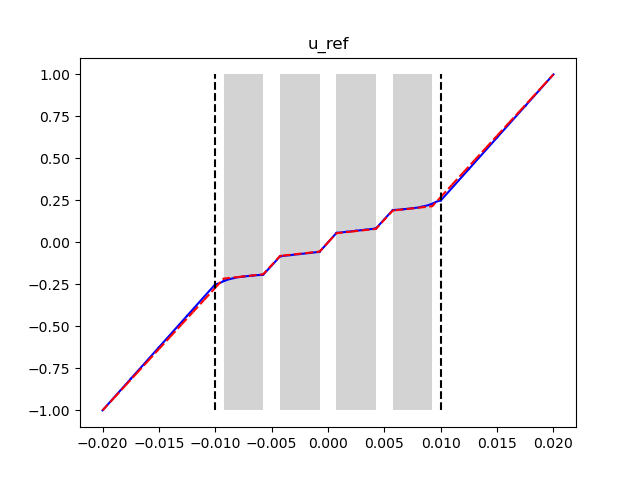

In [127]:
plt.figure()
plt.clf()
Draw(sum(sol_comp_MS), meshRef, r"$u_MS$", c="b")
# Draw(sol_comp_MS[2], meshRef, r"$u_MS$", clear=False, c="g")
# Draw(sol_pack_MS[0][0], meshRef, r"$u_MS$", clear=False, c="g")
# Draw(sol_pack_MS[1][0], meshRef, r"$u_MS$", clear=False, c="c")
# Draw(sol_pack_MS[2][0], meshRef, r"$u_MS$", clear=False, c="k")
Draw(sol_ref, meshMS, "u_ref", ls="--", c="red", clear=False, draw_mesh=False)

drawSheets()
plt.show()




In [126]:
gradgradMS.sol_comp
gradgradMS.sol_pack
sol_comp = [gradgradMS.sol_pack[i][0] * gradgradMS.sol_pack[i][1] for i in range(len(gradgradMS.sol_pack))]

### 1.3 Comparison 

pyPhiConstant 0.0
pyPhiConstant 0.00026223095257092705
zickzack -0.0007083298261779144
zickzack 0.00018386789025729415


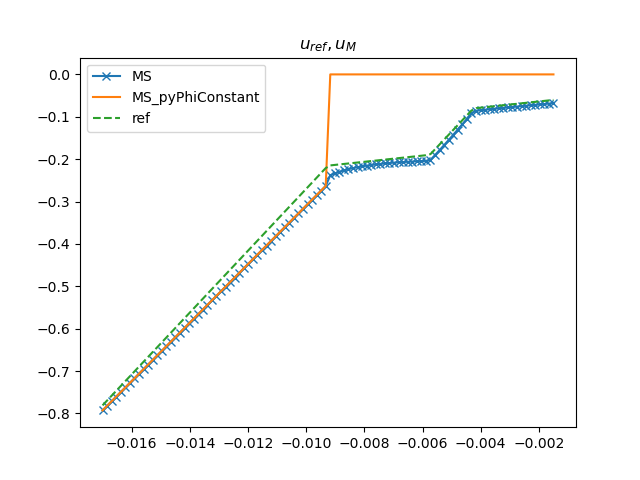

In [94]:


start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -d/2 - 2*dFe
end = -d/2 + d0+dFe*2

[print(sol_pack_MS[i][1].name, Integrate(sol_pack_MS[i][0], meshRef, definedon=meshMS.Materials("medium"))) for i in range(len(sol_comp_MS))]


evalOnLine(sum(sol_comp_MS) , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=100, x_start_fig=start);

#[evalOnLine(sol_comp_MS[i] , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+sol_pack_MS[i][1].name, show=False, N=100, x_start_fig=start) for i in range(len(sol_comp_MS))];
i = 0
evalOnLine(sol_comp_MS[i][0] , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+sol_pack_MS[i][1].name, show=False, N=100, x_start_fig=start)
evalOnLine(sol_ref , meshRef, [start, 0 , 0], [end, 0, 0], plot=True, ls='--', marker="", show=False, clear=False, label="ref", N = 100, title=r"$u_{ref}, u_{M}$", x_start_fig=start);


plt.legend()
plt.show()



In [95]:
energy =  Integrate(getIntegrand4BFI(gradgradMS.gradsol_pack, gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                definedon=meshMS.Materials("multiscale"))

gradgradMS.gradsol_pack[0][0]                                         

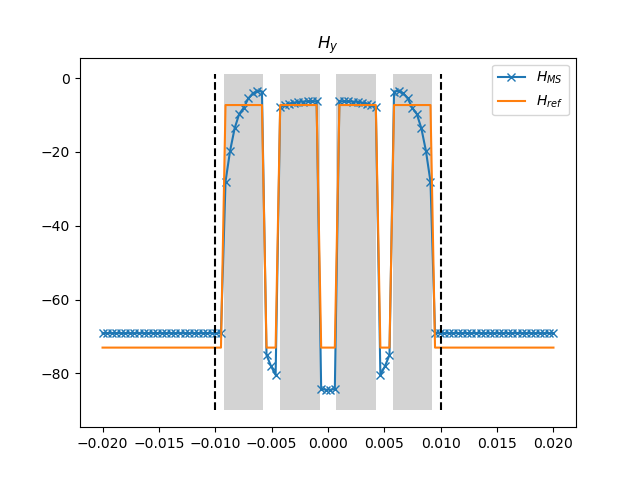

In [96]:
start = -D/2
end = D/2


plt.figure(3)
plt.clf()
drawSheets()
evalOnLine(sum(H_comp)[0] , meshRef, [start,0, 0], [end, 0, 0], plot=True, fig = plt.gcf(), ls='-', marker="x", clear=False, label=r"$H_{MS}$", show=False, N=100, title=r"$H_y$", x_start_fig=start);
#[evalOnLine(H_comp[i] , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+cl_gradgradMS.gradsol_pack[i][1].name, show=False, N=100,  x_start_fig=start) for i in range(len(H_comp))];

evalOnLine(-grad(sol_ref)[0] , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="", show=False, clear=False, label=r"$H_{ref}$", N = 100, title=r"$H_y$", x_start_fig=start);
drawSheets(min = -90)
plt.legend()
plt.show()

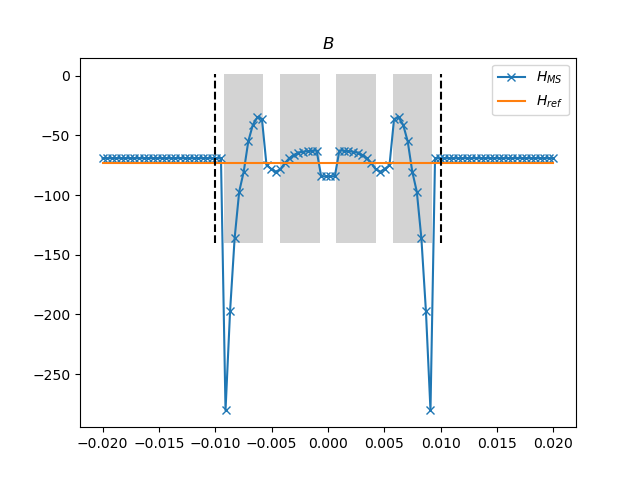

In [97]:
start = -D/2
end = D/2


plt.figure(3)
plt.clf()
drawSheets()
evalOnLine(lam * sum(H_comp)[0] , meshRef, [start,0, 0], [end, 0, 0], plot=True, fig = plt.gcf(), ls='-', marker="x", clear=False, label=r"$H_{MS}$", show=False, N=100, title=r"$B$", x_start_fig=start);
#[evalOnLine(lam * H_comp[i] , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+cl_gradgradMS.gradsol_pack[i][1].name, show=False, N=100,  x_start_fig=start) for i in range(len(H_comp))];

evalOnLine(- lam * grad(sol_ref)[0] , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="", show=False, clear=False, label=r"$H_{ref}$", N = 100, title=r"$B$", x_start_fig=start);
drawSheets(min = -140)
plt.legend()
plt.show()

In [98]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, f"{(energy_MS - energy_ref)/energy_ref * 100}%" )


Norm soll diff 0.0006305886954634739
diff energy 33.21899539443046 39.42671426288168 -6.207718868451224 -15.744956140804984%
